In [1]:
import numpy as np
import pandas as pd

import candas as can
from candas.lims import *

from tinydb import TinyDB, Query

lib = Librarian().load(library).open()

# Existing sequences

## Successfull GBP6 tripartite sequences

FP001 shared with competitor, so we'll replace RP001 with the EGFR graft

In [2]:
lib.Session().query(Amplicon).filter(Amplicon.name.in_(['A036.5','A057.4.2', 'A057.3.2'])).all()

[<Amplicon(id=82, name=A036.5, CoreBP=74, CoreGC=0.527, primers=['FP001', 'RP001'], probe=Pr001, sequence=GCAAGAACCAAGACCCTCAGGGAGGGAATCACAGTCACTGGGAATCGTCTGGGAACTCTGGCAGTGACTTATGTAGAGGCCATCAACAGTGGAGCAGTGCCTTGTCTGGAGAAT>,
 <Amplicon(id=80, name=A057.3.2, CoreBP=115, CoreGC=0.522, primers=['FP001', 'RP005'], probe=Pr002, sequence=GCAAGAACCAAGACCCTCAGCCCCGACACAAAATAAAACCACACCAAACACCCAACAACCCCACATCCCACCACCTCCCTACCCACTACCACTCCTCTCTAAACCCGCATGAAGCCTTCGTCTCACAGCTCTTTTCCCCTTAATTTCCGCACCTATT>,
 <Amplicon(id=24, name=A057.4.2, CoreBP=221, CoreGC=0.502, primers=['FP005', 'RP005'], probe=Pr003, sequence=TCTCTGATCGGTCCCTTTACTCGCCTCCCTACTCTTCATTCTATTCTCCTTCTCGTTCTTGTTTCTTCTTTTGTCTCTTTGCTTCCCTCGTATCTGTTCCTTTCCCGTCTCCCCATTCCCCGCCCCACTACCCAACACCCACCAATCAACCAAAACCTACAACCCATCCACACACCACCTCACTAACTCCTACCTCGCTCCTCTACACTTCACTGGCAACGCTCTGGTAACCTCTCTATCTCACCCCTTAATTTCCGCACCTATT>]

## EGFR components

### Primers

There are two forward (blocked) primer variations for EGFR. FP0013 displayed more consistent behavior, so we'll use that one.

In [3]:
lib.Session().query(Primer).filter(Primer._sequence.contains('GCAGCATGTCAAGATCACAGATT')).all()

[<Primer(id=37, name=FP0012, BP=23, GC=0.435, sequence=GCAGCATGTCAAGATCACAGATT>,
 <Primer(id=39, name=FP0013, BP=26, GC=0.423, sequence=GCAGCATGTCAAGATCACAGATTTTG>]

### EGFR L858R SNP site

SNP downstream from FP0013, up to (mismatched) 3' end of blocker

In [4]:
WT_graft = Snippet(name='WT_graft', sequence='GGCTGGCCAAACTGCT')
SNV_graft = Snippet(name='SNV_graft', sequence='GGCGGGCCAAACTGCT')

# Grafted sequences

In [43]:
lib.Session().rollback()

GBP6 = lib.Session().query(Amplicon).filter(Amplicon.name=='A036.5').one()
flanks = [lib.get_by_name('Snippet', 'Flank75_50a'), lib.get_by_name('Snippet', 'Flank125_50b')]

FP = lib.Session().query(Primer).filter(Primer.name=='FP001').one()
RP = lib.Session().query(Primer).filter(Primer.name=='FP0013').one()

old_core = GBP6.core
preserved_core_seq = old_core.sequence[:-len(WT_graft.sequence)]

WT_core = Core(name='C075_WT',
               description='WT EGFR-like tripartite target', 
               sequence=(preserved_core_seq + WT_graft.reverse_complement))
SNV_core = Core(name='C075_SNV',
                description='SNV EGFR-like tripartite target', 
                sequence=(preserved_core_seq + SNV_graft.reverse_complement))

WT_amplicon = Amplicon(name='A075_WT',
                       description='WT EGFR-like tripartite target', 
                       core=WT_core,
                       primers=[FP,RP], 
                       sequence=(FP.sequence + WT_core.sequence + RP.reverse_complement))
SNV_amplicon = Amplicon(name='A075_SNV',
                        description='SNV EGFR-like tripartite target', 
                        core=SNV_core,
                        primers=[FP,RP], 
                        sequence=(FP.sequence + SNV_core.sequence + RP.reverse_complement))

WT_fragment = Fragment(name='S075_WT',
                       description='WT EGFR-like tripartite target', 
                       amplicon=WT_amplicon,
                       flanks=flanks, 
                       sequence=(flanks[0].sequence + WT_amplicon.sequence + flanks[1].sequence))
SNV_fragment = Fragment(name='S075_SNV',
                        description='SNV EGFR-like tripartite target', 
                        amplicon=SNV_amplicon,
                        flanks=flanks, 
                        sequence=(flanks[0].sequence + SNV_amplicon.sequence + flanks[1].sequence))

print('S075_WT:', WT_fragment.sequence, '\n')
print('S075_SNV:', SNV_fragment.sequence, '\n')

S075_WT: GTTGAAGTGGTAGGGATTGCGTTTGTGTGTTCTGCTGTTCATGTGTCGTGCTTCTTTCCTCTAGTTTCCGTCATTGCAAGAACCAAGACCCTCAGGGAGGGAATCACAGTCACTGGGAATCGTCTGGGAACTCTGGCAGTGACTTATGTAGAGAGCAGTTTGGCCAGCCCAAAATCTGTGATCTTGACATGCTGCGATTCGTAACTGGACCGTACTAAAGCAGGATTCAGATTATTGGCCGTTCGTTCTTGTTAGCTCCGTCATTCAAATACCTTACCACATATCCAACCAAAGAGGCAAGTCTCATCAAAGCCCTCCCG 

S075_SNV: GTTGAAGTGGTAGGGATTGCGTTTGTGTGTTCTGCTGTTCATGTGTCGTGCTTCTTTCCTCTAGTTTCCGTCATTGCAAGAACCAAGACCCTCAGGGAGGGAATCACAGTCACTGGGAATCGTCTGGGAACTCTGGCAGTGACTTATGTAGAGAGCAGTTTGGCCCGCCCAAAATCTGTGATCTTGACATGCTGCGATTCGTAACTGGACCGTACTAAAGCAGGATTCAGATTATTGGCCGTTCGTTCTTGTTAGCTCCGTCATTCAAATACCTTACCACATATCCAACCAAAGAGGCAAGTCTCATCAAAGCCCTCCCG 



In [50]:
from candas.utils import getGC
import matplotlib.pyplot as plt


def profile_GC_content(sequence, window=100):    
    return [getGC(sequence[i:i+window]) for i in range(len(sequence)-window)]
    
def plot_GC_profile(sequence, window=100, ax=None):
    
    profile = profile_GC_content(sequence, window=window)
    
    ax = plt.gca() if ax is None else ax
    ax.plot(profile, label='Profile')
    ax.set_ylabel(f'GC Content\n{window}-base window')
    ax.set_xlabel('Window Start Position')
    
    ax.axhline(0.3, color='k', ls=':', label='Soft Limit')
    ax.axhline(0.2, color='k', ls='--', label='Hard Limit')
    
    ax.axhline(0.6, color='k', ls=':')
    ax.axhline(0.7, color='k', ls='--')
    
    ax.legend()

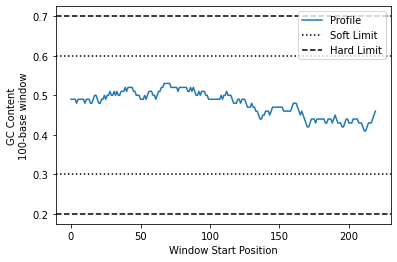

In [51]:
plot_GC_profile(WT_fragment.sequence)

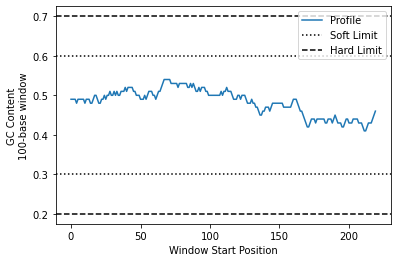

In [52]:
plot_GC_profile(SNV_fragment.sequence)

In [97]:
lib.Session().query(Fragment).filter(Fragment.name=='S056.1.1').one().amplicon.core.probe

<Probe(id=1, name=Pr003, fluor=HEX, BP=24, GC=0.542, sequence=TAGAGAGGTTACCAGAGCGTTGCC>